# Competition sulla regressione

# RICCARDO ESEGUI TUTTE LE CELLE ZIO BELLO

## Librerie

In [117]:
import numpy as np
import pandas as pd
import datetime as dt

from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold

import matplotlib.pyplot as plt

## Caricamento dataset

In [91]:
filePath = './DBs/SolarPark/train.txt'

dataframe = pd.read_csv(filePath)
dataframe.head(5)

,Time Frame,Date,Ta (C),Tm (C),I3 (W/m2),I15 (W/m2),P (kW)
0,16,3/5/12 4:55 PM,13.01,12.05,52.47,53.08,6.50
1,17,3/5/12 5:55 PM,11.81,8.50,10.41,10.95,0.01
2,18,3/5/12 6:55 PM,10.33,5.68,0.00,0.00,0.00
3,19,3/5/12 7:55 PM,9.66,4.67,0.00,0.00,0.00
4,20,3/5/12 8:55 PM,8.91,3.82,0.00,0.00,0.00


In [92]:
dataframe.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7902 entries, 0 to 7901
Columns: 7 entries, Time Frame to P (kW)
dtypes: float64(5), int64(1), object(1)
memory usage: 432.3+ KB


In [93]:
dataframe.dtypes

Time Frame      int64
Date           object
Ta (C)        float64
Tm (C)        float64
I3 (W/m2)     float64
I15 (W/m2)    float64
P (kW)        float64
dtype: object

## Preprocessing dei dati

Trasformiamo le stringhe delle date in numeri e diminuiamo la precisione dei tipi delle features

In [94]:

datetime_strings = dataframe['Date']
    
# Converte tutte le stringhe in oggetti Timestamp
datetimes = [pd.to_datetime(datetime, format='%m/%d/%y %I:%M %p') for datetime in datetime_strings]
    
# Estrae alcune informazioni dagli oggetti Timestamp
month = [datetime.month for datetime in datetimes]  # Meglio usare il mese se split temporale sequenziale
df_month = pd.DataFrame(month, columns=['Month'])
yday = [datetime.timetuple().tm_yday for datetime in datetimes]
df_yday = pd.DataFrame(yday, columns=['DayOfYear'])

dataframe = dataframe.merge(df_month, left_index=True, right_index=True)
dataframe = dataframe.merge(df_yday, left_index=True, right_index=True)
dataframe = dataframe.drop(columns=['Date'])

dataframe = dataframe[['Time Frame', 'Month', 'DayOfYear', 'Ta (C)', 'Tm (C)', 'I3 (W/m2)', 'I15 (W/m2)', 'P (kW)']]
dataframe

,Time Frame,Month,DayOfYear,Ta (C),Tm (C),I3 (W/m2),I15 (W/m2),P (kW)
0,16,3,65,13.01,12.05,52.47,53.08,6.50
1,17,3,65,11.81,8.50,10.41,10.95,0.01
2,18,3,65,10.33,5.68,0.00,0.00,0.00
3,19,3,65,9.66,4.67,0.00,0.00,0.00
4,20,3,65,8.91,3.82,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...
7897,2,2,32,0.00,0.00,0.00,0.00,0.00
7898,3,2,32,0.00,0.00,0.00,0.00,0.00
7899,4,2,33,10.25,6.83,0.00,0.00,0.00
7900,5,2,33,10.54,8.06,0.00,0.00,0.00


In [95]:
dataframe.dtypes

Time Frame      int64
Month           int64
DayOfYear       int64
Ta (C)        float64
Tm (C)        float64
I3 (W/m2)     float64
I15 (W/m2)    float64
P (kW)        float64
dtype: object

## Data exploration

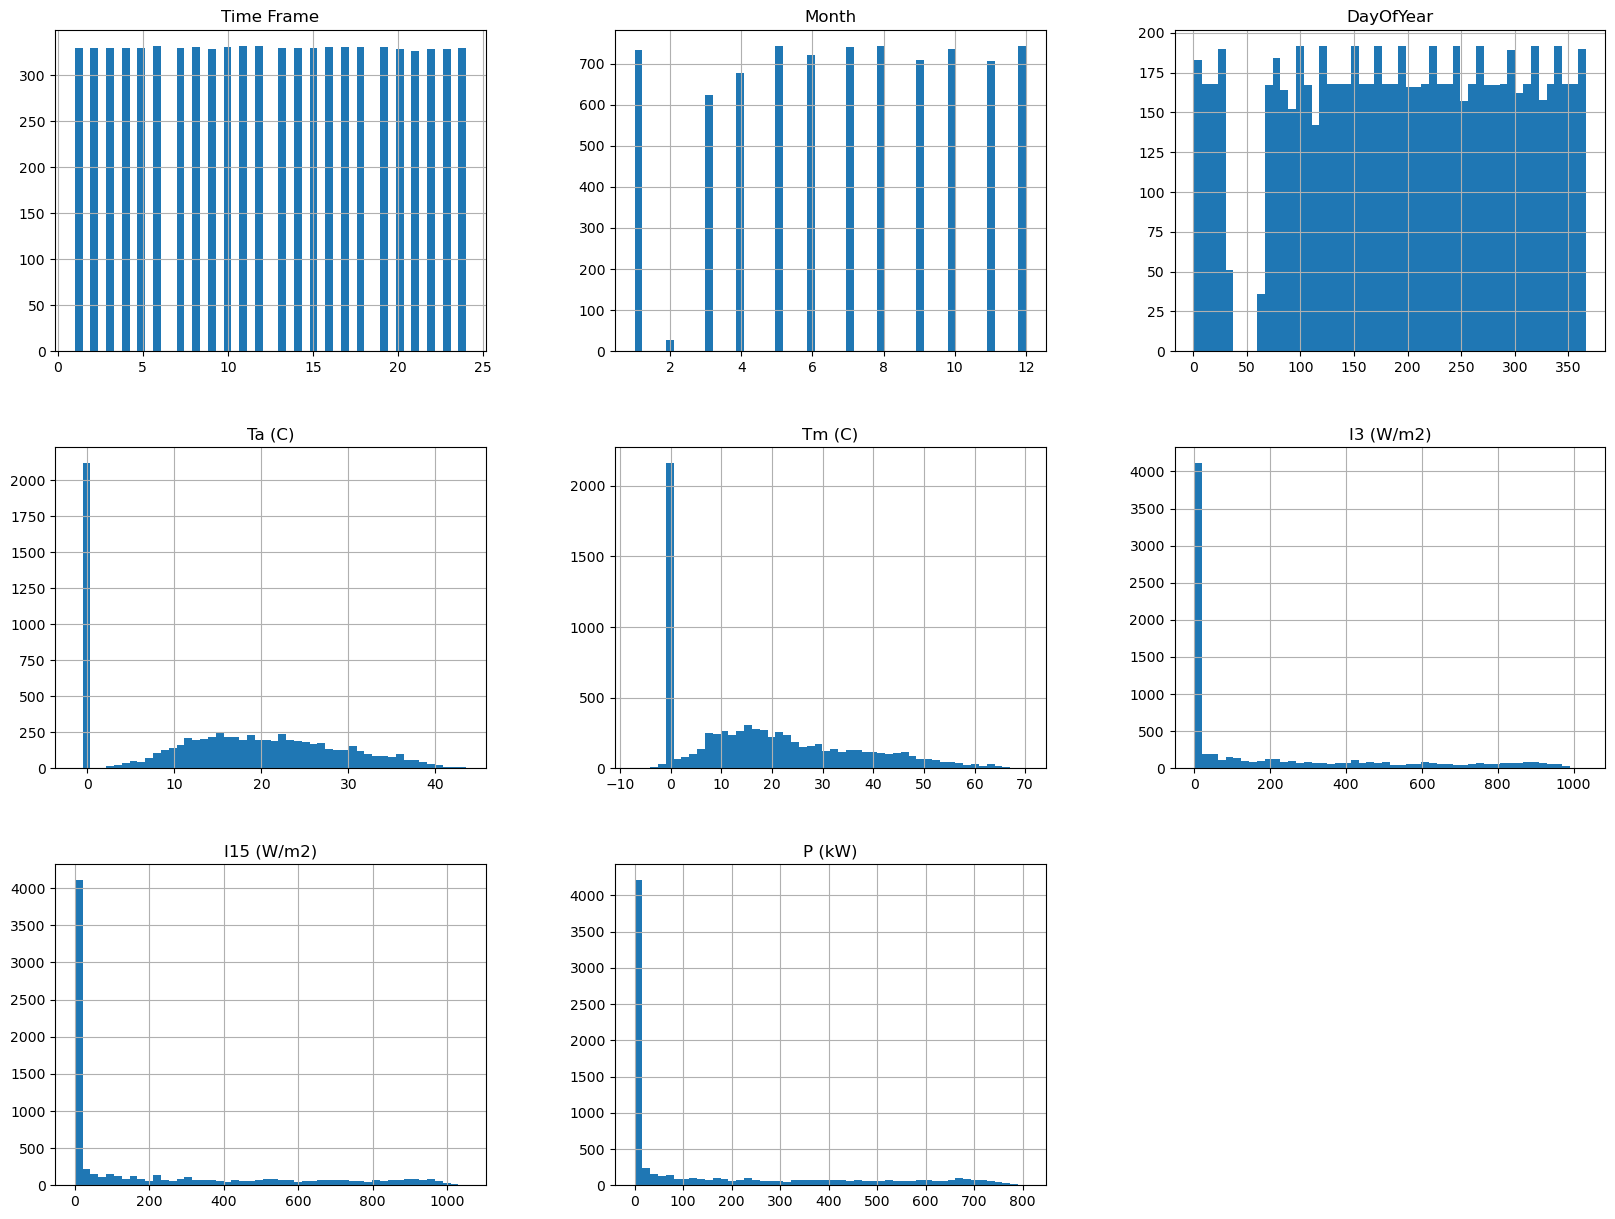

In [96]:
dataframe.hist(bins=50, figsize=(20, 15))
plt.show();

In [97]:
dataframe.isna().sum()

Time Frame    0
Month         0
DayOfYear     0
Ta (C)        0
Tm (C)        0
I3 (W/m2)     0
I15 (W/m2)    0
P (kW)        0
dtype: int64

Vedendo gli istogrammi, ci sono dei casi anomali con dei picchi sullo 0 nelle varie features. Andiamo a vedere nel dettaglio i pattern di questi valori.

In [98]:
dataframe[(dataframe['P (kW)'] == 0)]

,Time Frame,Month,DayOfYear,Ta (C),Tm (C),I3 (W/m2),I15 (W/m2),P (kW)
2,18,3,65,10.33,5.68,0.0,0.0,0.0
3,19,3,65,9.66,4.67,0.0,0.0,0.0
4,20,3,65,8.91,3.82,0.0,0.0,0.0
5,21,3,65,8.05,2.97,0.0,0.0,0.0
6,22,3,65,0.00,0.00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
7896,1,2,32,0.00,0.00,0.0,0.0,0.0
7897,2,2,32,0.00,0.00,0.0,0.0,0.0
7898,3,2,32,0.00,0.00,0.0,0.0,0.0
7899,4,2,33,10.25,6.83,0.0,0.0,0.0


In [99]:
dataframe[(dataframe['Ta (C)'] == 0) & (dataframe['Tm (C)'] == 0)]

,Time Frame,Month,DayOfYear,Ta (C),Tm (C),I3 (W/m2),I15 (W/m2),P (kW)
6,22,3,65,0.0,0.0,0.0,0.0,0.0
7,23,3,65,0.0,0.0,0.0,0.0,0.0
8,24,3,65,0.0,0.0,0.0,0.0,0.0
9,1,3,65,0.0,0.0,0.0,0.0,0.0
10,2,3,65,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
7894,23,2,32,0.0,0.0,0.0,0.0,0.0
7895,24,2,32,0.0,0.0,0.0,0.0,0.0
7896,1,2,32,0.0,0.0,0.0,0.0,0.0
7897,2,2,32,0.0,0.0,0.0,0.0,0.0


In [100]:
dataframe[(dataframe['Time Frame'] > 21) | (dataframe['Time Frame'] < 4)]

,Time Frame,Month,DayOfYear,Ta (C),Tm (C),I3 (W/m2),I15 (W/m2),P (kW)
6,22,3,65,0.0,0.0,0.0,0.0,0.0
7,23,3,65,0.0,0.0,0.0,0.0,0.0
8,24,3,65,0.0,0.0,0.0,0.0,0.0
9,1,3,65,0.0,0.0,0.0,0.0,0.0
10,2,3,65,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
7894,23,2,32,0.0,0.0,0.0,0.0,0.0
7895,24,2,32,0.0,0.0,0.0,0.0,0.0
7896,1,2,32,0.0,0.0,0.0,0.0,0.0
7897,2,2,32,0.0,0.0,0.0,0.0,0.0


In [101]:
dataframe[(dataframe['Tm (C)'] < 0)]

,Time Frame,Month,DayOfYear,Ta (C),Tm (C),I3 (W/m2),I15 (W/m2),P (kW)
204,4,3,74,4.82,-0.64,234.81,308.02,211.19
205,5,3,74,4.83,-0.64,454.82,538.27,406.48
206,6,3,74,5.34,-0.18,634.18,741.10,576.34
275,4,3,77,5.49,-1.56,636.50,742.56,575.18
276,5,3,77,5.84,-0.43,764.20,871.16,672.47
...,...,...,...,...,...,...,...,...
7827,4,1,30,3.78,-1.06,0.00,0.00,0.00
7828,5,1,30,3.47,-0.93,0.00,0.00,0.00
7829,6,1,30,3.16,-1.50,0.00,0.00,0.00
7830,7,1,30,3.37,-0.55,0.00,0.05,0.04


In [102]:
dataframe[(dataframe['I3 (W/m2)'] == 0)]

,Time Frame,Month,DayOfYear,Ta (C),Tm (C),I3 (W/m2),I15 (W/m2),P (kW)
2,18,3,65,10.33,5.68,0.0,0.0,0.00
3,19,3,65,9.66,4.67,0.0,0.0,0.00
4,20,3,65,8.91,3.82,0.0,0.0,0.00
5,21,3,65,8.05,2.97,0.0,0.0,0.00
6,22,3,65,0.00,0.00,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...
7897,2,2,32,0.00,0.00,0.0,0.0,0.00
7898,3,2,32,0.00,0.00,0.0,0.0,0.00
7899,4,2,33,10.25,6.83,0.0,0.0,0.00
7900,5,2,33,10.54,8.06,0.0,0.0,0.00


In [103]:
dataframe[(dataframe['I15 (W/m2)'] == 0)]

,Time Frame,Month,DayOfYear,Ta (C),Tm (C),I3 (W/m2),I15 (W/m2),P (kW)
2,18,3,65,10.33,5.68,0.0,0.0,0.00
3,19,3,65,9.66,4.67,0.0,0.0,0.00
4,20,3,65,8.91,3.82,0.0,0.0,0.00
5,21,3,65,8.05,2.97,0.0,0.0,0.00
6,22,3,65,0.00,0.00,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...
7897,2,2,32,0.00,0.00,0.0,0.0,0.00
7898,3,2,32,0.00,0.00,0.0,0.0,0.00
7899,4,2,33,10.25,6.83,0.0,0.0,0.00
7900,5,2,33,10.54,8.06,0.0,0.0,0.00


Si può vedere come per `Tm (C)` e `Ta (C)` quando hanno valore 0, anche tutto il resto della riga ha valore 0. Dunque, queste righe sono da cancellare in quanto potrebbero influenzare la regressione.

In [104]:
dataframe = dataframe[~((dataframe['Ta (C)'] == 0) & (dataframe['Tm (C)'] == 0))]

In [105]:
dataframe.head(12)

,Time Frame,Month,DayOfYear,Ta (C),Tm (C),I3 (W/m2),I15 (W/m2),P (kW)
0,16,3,65,13.01,12.05,52.47,53.08,6.50
1,17,3,65,11.81,8.50,10.41,10.95,0.01
2,18,3,65,10.33,5.68,0.00,0.00,0.00
3,19,3,65,9.66,4.67,0.00,0.00,0.00
4,20,3,65,8.91,3.82,0.00,0.00,0.00
5,21,3,65,8.05,2.97,0.00,0.00,0.00
11,3,3,66,4.90,1.30,0.00,0.00,0.00
12,4,3,66,4.71,1.42,0.00,0.00,0.00
13,5,3,66,4.75,1.22,22.09,25.61,14.75
14,6,3,66,5.08,2.00,153.43,186.61,127.16


Stesso discorso per le feature `I3 (W/m2)` e `I15 (W/m2)`.

In [106]:
dataframe = dataframe[~((dataframe['I3 (W/m2)'] == 0) & (dataframe['I15 (W/m2)'] == 0))]

In [107]:
dataframe.head(12)

,Time Frame,Month,DayOfYear,Ta (C),Tm (C),I3 (W/m2),I15 (W/m2),P (kW)
0,16,3,65,13.01,12.05,52.47,53.08,6.50
1,17,3,65,11.81,8.50,10.41,10.95,0.01
13,5,3,66,4.75,1.22,22.09,25.61,14.75
14,6,3,66,5.08,2.00,153.43,186.61,127.16
15,7,3,66,7.11,5.86,323.21,399.02,302.46
16,8,3,66,10.76,16.75,537.31,627.38,504.23
17,9,3,66,14.98,27.11,444.55,545.27,409.70
18,10,3,66,16.51,33.09,575.43,645.62,521.75
19,11,3,66,17.66,35.37,391.64,452.45,379.09
20,12,3,66,17.66,28.60,414.15,529.15,352.52


In [108]:
dataframe[dataframe['P (kW)'] == 0]

,Time Frame,Month,DayOfYear,Ta (C),Tm (C),I3 (W/m2),I15 (W/m2),P (kW)
1221,21,4,118,14.98,10.38,0.36,0.47,0.0
1245,21,4,119,15.76,11.48,0.79,0.63,0.0
1269,21,4,120,15.34,9.30,3.77,3.71,0.0
2647,7,6,178,29.32,37.03,781.76,808.29,0.0
2648,8,6,178,31.13,42.79,879.38,903.11,0.0
...,...,...,...,...,...,...,...,...
7432,15,1,13,14.67,18.26,138.32,160.00,0.0
7433,16,1,13,14.70,18.20,133.10,150.87,0.0
7434,17,1,13,14.70,18.20,133.10,150.87,0.0
7435,18,1,13,13.75,15.19,88.73,100.58,0.0


In [109]:
dataframe.shape

(4338, 8)

In questo modo abbiamo rimosso tutti i casi limite, mantenendo comunque dei pattern con `P (kW)` pari a 0.

## Divisione dei dati

Andiamo ora a dividere le features dalla variabile target e a creare il training e il validation set.

In [112]:
X = dataframe.values[:, :7]
y = dataframe.values[:, 7]

ahead_X = X[0:-1, :]
ahead_y = y[1:]

train_X, val_X, train_y, val_y = train_test_split(ahead_X, ahead_y, test_size=0.3, shuffle=False)

In [113]:
print("Dimensione train X", train_X.shape)
print("Dimensione val X", val_X.shape)
print("Dimensione train y", train_y.shape)
print("Dimensione val y", val_y.shape)

Dimensione train X (3035, 7)
Dimensione val X (1302, 7)
Dimensione train y (3035,)
Dimensione val y (1302,)


## Modelli di regressione

### LinearRegression

In [119]:
k_cv = KFold()

In [123]:
linreg_model = Pipeline([
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression())
])

linreg_grid = {
    "linreg__fit_intercept": [True, False],
    "linreg__positive": [True, False]
}

linreg_gs = GridSearchCV(linreg_model, linreg_grid, cv=k_cv, scoring='neg_mean_squared_error', n_jobs=-1)
linreg_gs.fit(train_X, train_y)

print("Iperparametri scelti:", linreg_gs.best_params_)

train_y_predicted = linreg_gs.predict(train_X)
print("Train RMSE:", np.sqrt(mean_squared_error(train_y, train_y_predicted)))

val_y_predicted = linreg_gs.predict(val_X)
print("Validation RMSE:", np.sqrt(mean_squared_error(val_y, val_y_predicted)))

Iperparametri scelti: {'linreg__fit_intercept': True, 'linreg__positive': False}
Train RMSE: 104.45443622942632
Validation RMSE: 122.17877080087315


### RandomForestRegressor

In [126]:
rfr_model = Pipeline([
    ("scaler", StandardScaler()),
    ("rfr", RandomForestRegressor())
])

rfr_grid = {
    "rfr__n_estimators": range(100, 1000, 100),
    #"rfr__criterion": ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    "rfr__max_features": ['sqrt', 'log2'],
    "rfr__max_depth": range(1, 20)
}

rfr_gs = GridSearchCV(rfr_model, rfr_grid, cv=k_cv, scoring='neg_mean_squared_error', n_jobs=-1)
rfr_gs.fit(train_X, train_y)

print("Iperparametri scelti:", rfr_gs.best_params_)

train_y_predicted = rfr_gs.predict(train_X)
print("Train RMSE:", np.sqrt(mean_squared_error(train_y, train_y_predicted)))

val_y_predicted = rfr_gs.predict(val_X)
print("Validation RMSE:", np.sqrt(mean_squared_error(val_y, val_y_predicted)))

Iperparametri scelti: {'rfr__max_depth': 13, 'rfr__max_features': 'log2', 'rfr__n_estimators': 200}
Train RMSE: 33.94204869827875
Validation RMSE: 110.18916032553406
